In [20]:
#Import Necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [21]:
# Load dataset
df = pd.read_csv("AMZN_1997-05-15_2025-02-21.csv")
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# Display basic info and first few rows
df_info = df.info()
df_head = df.head()

# Add moving averages
df["MA7"] = df["close"].rolling(window=7).mean()  # 7-day moving average
df["MA21"] = df["close"].rolling(window=21).mean()  # 21-day moving average

# Add Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["RSI"] = compute_rsi(df["close"])

# Add Bollinger Bands
df["upper_bb"] = df["MA21"] + (df["close"].rolling(window=21).std() * 2)
df["lower_bb"] = df["MA21"] - (df["close"].rolling(window=21).std() * 2)

# Drop NaN values caused by rolling calculations
df.dropna(inplace=True)

# Select features and normalize
features = ["close", "MA7", "MA21", "RSI", "upper_bb", "lower_bb", "volume"]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])


<class 'pandas.core.frame.DataFrame'>
Index: 6986 entries, 1997-05-15 00:00:00-04:00 to 2025-02-20 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       6986 non-null   float64
 1   high       6986 non-null   float64
 2   low        6986 non-null   float64
 3   close      6986 non-null   float64
 4   adj_close  6986 non-null   float64
 5   volume     6986 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 382.0+ KB


<ipython-input-21-5d23e35f1542>:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["date"] = pd.to_datetime(df["date"])


In [22]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0])  # Predicting 'close' price
    return np.array(sequences), np.array(labels)

seq_length = 60  # 60-day window
X, y = create_sequences(scaled_data, seq_length)

# Train-test split (80% training)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [15]:
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, return_sequences=False),
    Dropout(0.2),
    Dense(units=50),
    Dense(units=1)  # Predicting 'close' price
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - loss: 0.0017 - val_loss: 0.0064
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - loss: 1.3244e-04 - val_loss: 0.0017
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - loss: 1.4309e-04 - val_loss: 0.0053
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 1.5778e-04 - val_loss: 0.0020
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - loss: 1.0868e-04 - val_loss: 0.0020
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 1.2663e-04 - val_loss: 0.0018
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - loss: 1.2061e-04 - val_loss: 0.0016
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - loss: 1.5885e-04 - val_loss: 0.0017
Epoch 9/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - loss: 1.2419e-04 - val_loss: 0.0030
Epoch 10/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 1.6645e-04 - val_loss: 0.0039
Epoch 11/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - loss: 1.3375e-04 - val_los

In [23]:
y_test_pred = model.predict(X_test)

# Convert predictions back to actual price scale
y_test_pred_actual = scaler.inverse_transform(
    np.column_stack([y_test_pred] + [np.zeros(y_test_pred.shape)] * (len(features) - 1))
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.column_stack([y_test] + [np.zeros(y_test.shape)] * (len(features) - 1))
)[:, 0]

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_test_pred_actual)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual)
accuracy = 100 - (mape * 100)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Model Accuracy: {accuracy:.2f}%")


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Mean Squared Error (MSE): 376.4124
Root Mean Squared Error (RMSE): 19.4014
Mean Absolute Percentage Error (MAPE): 0.0894
Model Accuracy: 91.06%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━

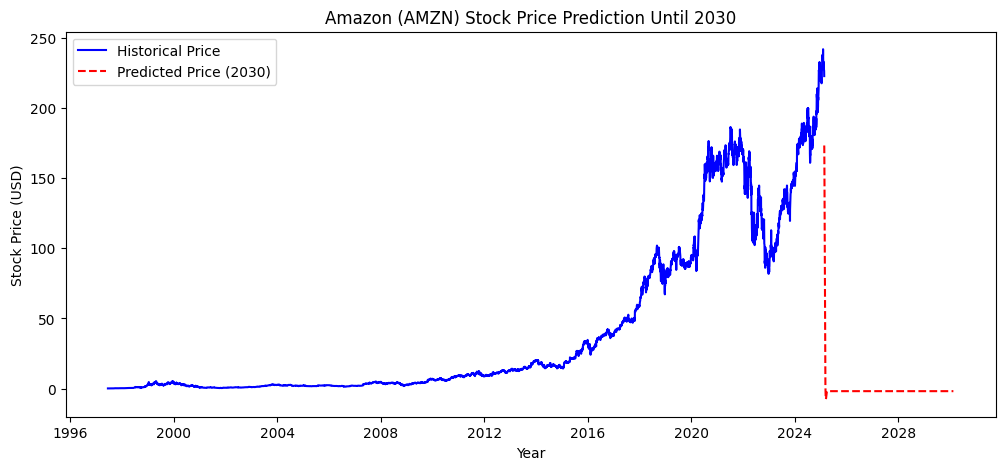

In [26]:
future_days = (2030 - 2025) * 365  # 5 years of daily predictions
predictions = []
input_seq = X_test[-1]

for _ in range(future_days):
    next_pred = model.predict(input_seq.reshape(1, seq_length, len(features)))
    predictions.append(next_pred[0][0])
    input_seq = np.append(input_seq[1:], [[next_pred[0][0]] + [0] * (len(features) - 1)], axis=0)

# Convert predictions back to actual price scale
predicted_prices = scaler.inverse_transform(
    np.column_stack([predictions] + [np.zeros(len(predictions))] * (len(features) - 1))
)[:, 0]

# Generate future dates
future_dates = pd.date_range(start=df.index[-1], periods=future_days, freq="D")

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["close"], label="Historical Price", color="blue")
plt.plot(future_dates, predicted_prices, label="Predicted Price (2030)", color="red", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.title("Amazon (AMZN) Stock Price Prediction Until 2030")
plt.legend()
plt.show()
